In this NB, we check if artificially "destroying" the layout actually worsens the score significantly to check for sanity in the model.

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image
import json
from math import prod
from huggingface_hub import hf_hub_download
import tqdm
transform_t_to_pil = T.ToPILImage()
transform_to_t = transforms.Compose([transforms.ToTensor()])
import utils
from utils import get_all_bounding_boxes, segment, calculate_initial_theta, stack_alpha_aware, AestheticPredictor, get_random_initial_position
# from lion_pytorch import Lion
from datetime import datetime
import random

In [3]:
# appsthetics_predictor = torch.load("./resnet_50_20_epochs_2024-05-13T14:03")
appsthetics_predictor = torch.load("Dataset_estetica/Regressao/model34-1cycle-2ndStage-best")

In [5]:
appsthetics_predictor["model"].eval()
1

1

In [6]:
im = Image.open('combined/5373.jpg')
im = im.convert('RGBA')
im = im.resize((1440, 2560), Image.Resampling.LANCZOS)


with open("combined/5373.json", "r") as f:
    image_json = json.load(f)

reduced_segments = [s for s in segment(im,image_json) if (prod(s[0].size) < 0.80*prod(im.size)) and (prod(s[0].size)>1)]
even_more_reduced_segments = [reduced_segments[i] for i in [2,4,5,6,7,8,10,11,12]]

In [7]:
class MultiSegmentUIOptimizerWithBackgroundParam(torch.nn.Module):
    def __init__(self,segments_and_positions: list, original_image_size: tuple, random_initial_state: bool):
        super().__init__()
        self.original_image_size = original_image_size
        self.segments_and_positions = segments_and_positions
        self.canvas_size = (1,3,original_image_size[1],original_image_size[0])
        print(f"Canvas size is {self.canvas_size}")

        initial_vector = []
        for segment,position in segments_and_positions:
            if random_initial_state:
                initial_theta = get_random_initial_position(segment,original_image_size,position)
            else:
                initial_theta = calculate_initial_theta(segment,original_image_size,position)
            initial_vector.append([initial_theta[0][2],initial_theta[1][2]])

        self.coordinates = torch.nn.Parameter(torch.tensor(initial_vector))
        self.static_coordinates = torch.tensor(initial_vector)
        print(self.coordinates)
        # self.background_color = torch.nn.Parameter(torch.tensor(np.array([1.0,1.0,1.0]),dtype=torch.float))
        self.background_color = torch.tensor(np.array([1.0,1.0,1.0]),dtype=torch.float)
        

    def forward(self):
        segments_on_canvas = []

        # Create background image from parameter
        bg_col = torch.clamp(self.background_color, min=0, max=1)
        #print(f"Clamped bg to {bg_col}")
        red = torch.tile(bg_col[0],self.original_image_size[::-1])
        green = torch.tile(bg_col[1],self.original_image_size[::-1])
        blue = torch.tile(bg_col[2],self.original_image_size[::-1])
        alpha = torch.tile(torch.tensor(0.0),self.original_image_size[::-1])
        background = torch.stack([red,green,blue,alpha]).unsqueeze(0)
        #print(background.detach().sum())
        #background = torch.tile(self.background_color,self.original_image_size)
        
        
        for n in range(len(self.segments_and_positions)):
            
            # We need to calculate the proper ratios, to artificially warp the segment on to a bigger canvas without distorting it (see notebook 01)
            x_ratio = self.original_image_size[0] / self.segments_and_positions[n][0].size[0]
            y_ratio = self.original_image_size[1] / self.segments_and_positions[n][0].size[1]
            
            # Affine matrix
            theta = [
                [x_ratio, 0.0    , 0.0],
                [0.0    , y_ratio, 0.0]
            ]
            theta_tensor = torch.as_tensor(theta)[None]
            if n == 6:
                theta_tensor[0][0][2]+=self.coordinates[n][0]
                theta_tensor[0][1][2]+=self.coordinates[n][1]
            else:
                theta_tensor[0][0][2]+=self.static_coordinates[n][0]
                theta_tensor[0][1][2]+=self.static_coordinates[n][1]
            
            # Generate flow field
            grid = F.affine_grid(theta_tensor, self.canvas_size).type(torch.FloatTensor)
            x = F.grid_sample(transform_to_t(self.segments_and_positions[n][0]).unsqueeze(0), grid)
            segments_on_canvas.append(x)

        segments_on_canvas.append(background)

        return segments_on_canvas

Canvas size is (1, 3, 2560, 1440)
Parameter containing:
tensor([[ -5.8048,  13.3037],
        [  1.6321,  21.3044],
        [  0.5895,  12.0661],
        [  0.5249,   5.3056],
        [  1.4158,  11.2097],
        [  1.8943,   9.2690],
        [ -1.8578, -10.5006],
        [  0.0000, -12.3693],
        [  0.0000,  29.4762]], dtype=torch.float64, requires_grad=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


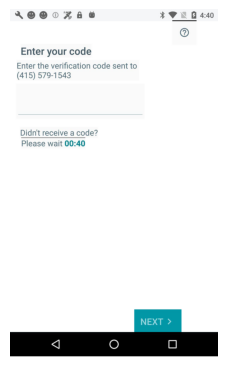

tensor([[0.3112]], grad_fn=<AddmmBackward0>)


In [9]:
msUIo_wbg_gr = MultiSegmentUIOptimizerWithBackgroundParam(even_more_reduced_segments, im.size, False)
canvasses = msUIo_wbg_gr()

generated_image = stack_alpha_aware(canvasses)

generated_image = generated_image[:3]

plt.imshow(generated_image.detach().permute(1, 2, 0))
plt.axis('off')
plt.show()

score = appsthetics_predictor["model"](generated_image.unsqueeze(0))
print(score)

Canvas size is (1, 3, 2560, 1440)
Original would have been: [[ 8.571429  0.       -5.804762]
 [ 0.       15.238095 13.30372 ]]
Now is [[ 8.571429  0.       -4.169353]
 [ 0.       15.238095  4.181071]]
Original would have been: [[ 2.93279   0.        1.632134]
 [ 0.       27.526882 21.304402]]
Now is [[ 2.93279   0.       -1.557174]
 [ 0.       27.526882 21.57721 ]]
Original would have been: [[ 1.698113  0.        0.589518]
 [ 0.       18.028169 12.066054]]
Now is [[ 1.698113  0.        0.095668]
 [ 0.       18.028169 -0.36227 ]]
Original would have been: [[ 1.621622  0.        0.524925]
 [ 0.       10.578512  5.305598]]
Now is [[ 1.621622  0.        0.419284]
 [ 0.       10.578512  3.07675 ]]
Original would have been: [[ 2.67658   0.        1.415779]
 [ 0.       33.684211 11.209663]]
Now is [[ 2.67658   0.       -1.363292]
 [ 0.       33.684211 14.972477]]
Original would have been: [[ 3.243243  0.        1.894294]
 [ 0.       33.684211  9.269038]]
Now is [[ 3.243243  0.       -2.226154

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


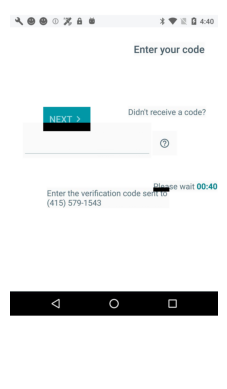

tensor([[0.3357]], grad_fn=<AddmmBackward0>)


In [11]:
msUIo_wbg_gr = MultiSegmentUIOptimizerWithBackgroundParam(even_more_reduced_segments, im.size, True)
canvasses = msUIo_wbg_gr()

generated_image = stack_alpha_aware(canvasses)

generated_image = generated_image[:3]

plt.imshow(generated_image.detach().permute(1, 2, 0))
plt.axis('off')
plt.show()

score = appsthetics_predictor["model"](generated_image.unsqueeze(0))
print(score)